In [0]:
#!pip install pydrive

In [0]:
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials 

In [ ]:
# 1. Authenticate and create the PyDrive client.

#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)
#file_id = '1vmNjaOxUU-hH-O7_5_iElFQhAZvt8ESS'
#downloaded = drive.CreateFile({'id': file_id})
#downloaded.GetContentFile('grip_str.sas7bdat')

In [0]:
# 자료 불러오기
import pandas as pd
dt_grip = pd.read_sas("grip_str.sas7bdat", format="sas7bdat").dropna() 

In [0]:
dt_grip.shape

(11323, 48)

In [0]:
dt_grip.head()

,ID,sex,age,ho_incm,edu,occp,marri_1,sm_presnt,dr_high,pa_aerobic,...,N_K,N_VA,N_CAROT,N_RETIN,N_B1,N_B2,N_NIAC,N_VITC,max_grip_rt,max_grip_lt
0,b'A209716213',2.0,30.0,3.0,4.0,7.0,2.0,0.0,0.0,1.0,...,3035.899499,1335.998584,7476.633795,88.505252,2.524458,1.702372,13.792368,69.967986,28.4,26.4
2,b'A209716216',1.0,29.0,3.0,4.0,7.0,2.0,0.0,0.0,1.0,...,5018.153615,2181.289291,11339.248496,291.693538,3.853337,3.065095,22.947486,65.287764,50.6,47.8
3,b'A209724716',1.0,65.0,1.0,1.0,3.0,1.0,1.0,0.0,1.0,...,1952.808521,452.073639,2102.115596,100.982500,1.164780,1.098967,11.789950,43.467542,33.1,33.6
4,b'A209731516',1.0,66.0,2.0,4.0,7.0,1.0,0.0,0.0,1.0,...,2339.124348,854.972445,4817.173801,51.367319,1.015765,0.579514,10.199538,56.882524,36.5,35.4
6,b'A209736615',2.0,41.0,3.0,3.0,7.0,1.0,0.0,1.0,1.0,...,2214.850076,276.389343,1509.860228,19.627705,0.932423,0.742740,16.719703,146.408221,31.7,29.6


In [0]:
# 변수명 속성 확인하기
#dt_grip.info()

In [0]:
# 원본파일을 복사하여 사용, 원자료는 조작하지 않는다
dt = dt_grip.copy()

# index와 동일한 ID 변수 삭제
dt = dt.drop(columns = ['ID'], axis = 1)

In [0]:
## 변수 속성 변경
features_nm_list = [dt.columns]
cat_features_nm_list = ['sex', 'ho_incm', 'edu', 'occp', 'marri_1', 'sm_presnt', 'dr_high', 'pa_aerobic', 'pa_walk', 'pa_muscle']
int_features_nm_list = ['age']

#카테고리 변수 속성변경
for i in cat_features_nm_list:
  dt[i]=pd.Categorical(dt[i])
  
# 정수형 속성 변경 
for i in int_features_nm_list:
  dt[i]= dt[i].astype('int64')


In [0]:
#dt.info()

In [0]:
#연령을 범위로 구분하기
labels = ["{0} - {1}".format(i, i + 10) for i in range(19, 80, 10)]
labels

['19 - 29', '29 - 39', '39 - 49', '49 - 59', '59 - 69', '69 - 79', '79 - 89']

In [0]:
dt['age'] = pd.cut(dt.age, range(19, 90, 10), right=False, labels=labels)

In [0]:
# Target 컬럼 생성 - 왼손 악력과 오른손 악력 중 최대값을 타겟으로 한다.
target_dt = dt[['max_grip_rt', 'max_grip_lt']].max(axis = 1)
features_dt = dt.drop(columns = ['max_grip_rt', 'max_grip_lt'], axis = 1)
# 키, 몸무게, BMI, 허리둘레는 중첩됨으로BMI 제외
features_dt = dt.drop(columns = ['HE_BMI'], axis = 1)

In [0]:
target_dt.head()

0    28.4
2    50.6
3    33.6
4    36.5
6    31.7
dtype: float64

In [0]:
# 키와 몸무게, BMI 변수와 악력의 상관관계
# 상관계수 계산을 위해 변수선택하여 데이터 만들기
corr_dt = dt.filter(['HE_ht','HE_wt','HE_BMI'])
corr_dt['max_grip'] = target_dt
corr_dt.head()

,HE_ht,HE_wt,HE_BMI,max_grip
0,153.4,68.1,28.939858,28.4
2,171.2,84.0,28.659708,50.6
3,160.8,52.2,20.188238,33.6
4,168.8,68.8,24.145909,36.5
6,162.2,80.5,30.598080,31.7


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = corr_dt.corr()
#sns.heatmap(corr)
#sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
corr.style.background_gradient().set_precision(2)

,HE_ht,HE_wt,HE_BMI,max_grip
HE_ht,1,0.63,0.036,0.75
HE_wt,0.63,1,0.8,0.61
HE_BMI,0.036,0.8,1,0.2
max_grip,0.75,0.61,0.2,1


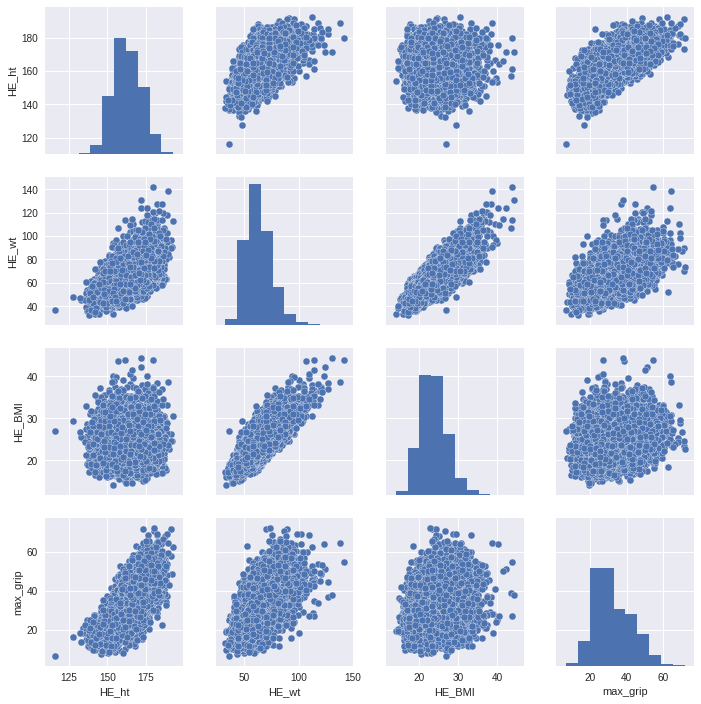

In [0]:
# seaborn의 Correlogram은 탐색 분석에 아주 좋다.
sns.pairplot(corr_dt)
sns.plt.show()

In [0]:
# one-hot-encoding 
features_dt_dm =  pd.get_dummies(features_dt)

In [0]:
features_dt_dm.head()

,HE_ht,HE_wt,HE_wc,HE_HP,HE_DM,HE_HCHOL,GS_use,N_WAT_C,N_INTK,N_EN,...,sm_presnt_0.0,sm_presnt_1.0,dr_high_0.0,dr_high_1.0,pa_aerobic_0.0,pa_aerobic_1.0,pa_walk_0.0,pa_walk_1.0,pa_muscle_0.0,pa_muscle_1.0
0,153.4,68.1,81.9,1.0,1.0,0.0,1.0,3.5,1198.226616,1930.920992,...,1,0,1,0,0,1,1,0,0,1
2,171.2,84.0,85.5,2.0,1.0,0.0,1.0,4.0,2099.617699,3007.329713,...,1,0,1,0,0,1,0,1,0,1
3,160.8,52.2,71.0,3.0,3.0,0.0,1.0,3.0,779.230888,1502.406756,...,0,1,1,0,0,1,0,1,1,0
4,168.8,68.8,84.0,2.0,1.0,0.0,1.0,5.0,1165.590400,1116.380721,...,1,0,1,0,0,1,1,0,1,0
6,162.2,80.5,98.4,2.0,1.0,0.0,1.0,15.0,2336.472416,2465.075672,...,1,0,0,1,0,1,0,1,1,0


In [0]:
# 카테고리 피쳐들의 비율 확인
for i in cat_features_nm_list:
  print((dt[i].value_counts()/dt[i].count())*100)

2.0    57.369955
1.0    42.630045
Name: sex, dtype: float64
4.0    30.080367
3.0    28.393535
2.0    24.675439
1.0    16.850658
Name: ho_incm, dtype: float64
4.0    35.803232
3.0    33.639495
1.0    20.259649
2.0    10.297624
Name: edu, dtype: float64
7.0    40.068886
1.0    14.015720
3.0    12.602667
2.0    10.271130
5.0     9.564603
6.0     8.495982
4.0     4.981012
Name: occp, dtype: float64
1.0    83.882363
2.0    16.117637
Name: marri_1, dtype: float64
0.0    83.264153
1.0    16.735847
Name: sm_presnt, dtype: float64
0.0    89.976155
1.0    10.023845
Name: dr_high, dtype: float64
0.0    51.2585
1.0    48.7415
Name: pa_aerobic, dtype: float64
0.0    60.257882
1.0    39.742118
Name: pa_walk, dtype: float64
0.0    79.872825
1.0    20.127175
Name: pa_muscle, dtype: float64


In [0]:
# Train데이터와 Test를 나눈다.
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_dt_dm, target_dt, random_state=0)

In [0]:
X_train.columns

Index(['HE_ht', 'HE_wt', 'HE_wc', 'HE_HP', 'HE_DM', 'HE_HCHOL', 'GS_use',
       'N_WAT_C', 'N_INTK', 'N_EN', 'N_WATER', 'N_PROT', 'N_FAT', 'N_SFA',
       'N_MUFA', 'N_PUFA', 'N_N3', 'N_N6', 'N_chol', 'N_CHO', 'N_tdf', 'N_CA',
       'N_PHOS', 'N_FE', 'N_NA', 'N_K', 'N_VA', 'N_CAROT', 'N_RETIN', 'N_B1',
       'N_B2', 'N_NIAC', 'N_VITC', 'max_grip_rt', 'max_grip_lt', 'sex_1.0',
       'sex_2.0', 'age_19 - 29', 'age_29 - 39', 'age_39 - 49', 'age_49 - 59',
       'age_59 - 69', 'age_69 - 79', 'age_79 - 89', 'ho_incm_1.0',
       'ho_incm_2.0', 'ho_incm_3.0', 'ho_incm_4.0', 'edu_1.0', 'edu_2.0',
       'edu_3.0', 'edu_4.0', 'occp_1.0', 'occp_2.0', 'occp_3.0', 'occp_4.0',
       'occp_5.0', 'occp_6.0', 'occp_7.0', 'marri_1_1.0', 'marri_1_2.0',
       'sm_presnt_0.0', 'sm_presnt_1.0', 'dr_high_0.0', 'dr_high_1.0',
       'pa_aerobic_0.0', 'pa_aerobic_1.0', 'pa_walk_0.0', 'pa_walk_1.0',
       'pa_muscle_0.0', 'pa_muscle_1.0'],
      dtype='object')

In [0]:
y_train.shape

(8492,)

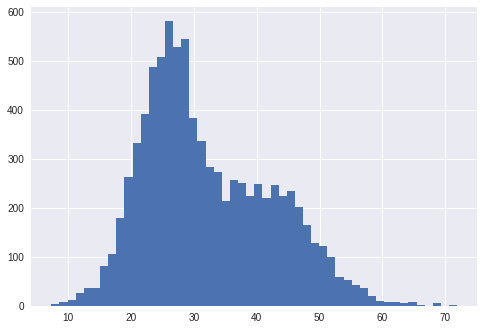

In [0]:
# train set 의 target 분포
import matplotlib.pyplot as plt
y_train.hist(bins=50)
plt.show()

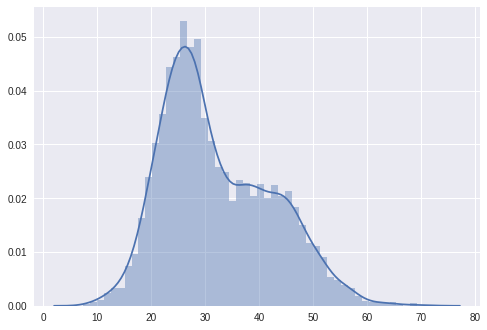

In [0]:
import seaborn as sns
sns.distplot(y_train, bins=50)

In [1]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


### Ridge Regression(능선회귀)
----
    Ridge regression은 계수의 크기에 패널티(penality)를 부과함으로써 최소자승법(Ordinary least squares, 오차의 제곱합을 최소가 되는 해를 구하는)의 문제를 일부 해결한다. 
    오래된 회귀용 선형 알고리즘이다. 
    예측값과 타겟값 사이의 평균제곱오차를 최소화하는 파라메타 찾는다
    매개변수가 없는 것이 장점이지만, 모델의 복잡도를 제어할 수 없다는 단점이 있다.
    손실함수는 기존선형회귀의 RSS(잔차 제곱식)와 패널티 두가지 합으로 이루어져 있다. 
    hyperparameter인 alpha를 설정

In [0]:
%%time
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import Ridge

model = Ridge()

#amx_iter은 반복 실행하는 최대 횟수
max_iter = [1000]
alphas = [1.0, 10.0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
## 알파값을 좀더 세밀하게 

param_grid = dict(max_iter=max_iter, alpha = alphas)
##그리드 서치 : 회귀의 평가지표는 R^2이다. 
grid_ridge = GridSearchCV(model, param_grid, scoring='r2', cv=5)

grid_result=grid_ridge.fit(X_train, y_train)

CPU times: user 2.2 s, sys: 2.27 s, total: 4.47 s
Wall time: 2.28 s


In [0]:
grid_result.best_params_

{'alpha': 100, 'max_iter': 1000}

In [0]:
grid_result.best_score_

0.9919265563921535

In [0]:
print(grid_result.best_params_)
print("릿지회귀에 대한 R^2값: {:.2f}".format(grid_result.best_score_))

{'alpha': 100, 'max_iter': 1000}
릿지회귀에 대한 R^2값: 0.99


In [0]:
# 학습한 모형을 시각화
df = pd.DataFrame(grid_result.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x['alpha'])
df["r2"] = df["mean_validation_score"].apply(lambda x:x)
df

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,parameters,mean_validation_score,cv_validation_scores,alpha,r2
0,"{'alpha': 1.0, 'max_iter': 1000}",0.991919,"[0.9920512565500498, 0.9911276885493382, 0.992...",1.0,0.991919
1,"{'alpha': 10.0, 'max_iter': 1000}",0.991920,"[0.9920522940138419, 0.9911278651970167, 0.992...",10.0,0.991920
2,"{'alpha': 20, 'max_iter': 1000}",0.991921,"[0.9920533785571279, 0.9911280342674792, 0.992...",20.0,0.991921
3,"{'alpha': 30, 'max_iter': 1000}",0.991922,"[0.9920543967193685, 0.9911281777744035, 0.992...",30.0,0.991922
4,"{'alpha': 40, 'max_iter': 1000}",0.991923,"[0.9920553535468047, 0.9911282984711944, 0.992...",40.0,0.991923
5,"{'alpha': 50, 'max_iter': 1000}",0.991924,"[0.9920562535936059, 0.9911283987558331, 0.992...",50.0,0.991924
6,"{'alpha': 60, 'max_iter': 1000}",0.991924,"[0.9920571009782382, 0.991128480731871, 0.9929...",60.0,0.991924
7,"{'alpha': 70, 'max_iter': 1000}",0.991925,"[0.9920578994324113, 0.9911285462549435, 0.992...",70.0,0.991925
8,"{'alpha': 80, 'max_iter': 1000}",0.991926,"[0.9920586523438688, 0.9911285969693903, 0.992...",80.0,0.991926
9,"{'alpha': 90, 'max_iter': 1000}",0.991926,"[0.9920593627939263, 0.9911286343378016, 0.992...",90.0,0.991926


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


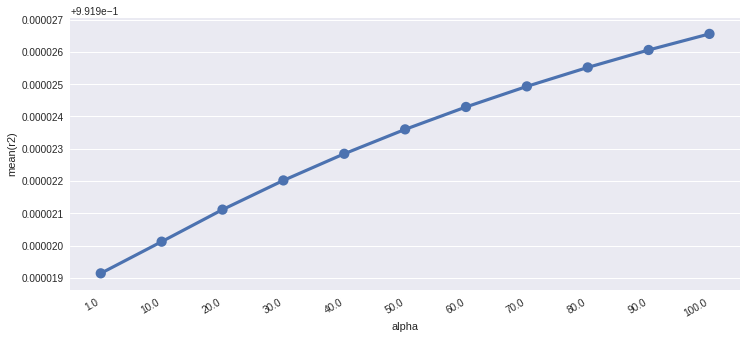

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
fig.set_size_inches(12, 5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df, x="alpha", y="r2")
#fig.suptitle('Change of alpha value and R squre', fontsize=12)
# 해당 경고에 대한 수정을 알 수 없음

In [0]:
print("테스트 대한 R^2값: {:.2f}".format(grid_result.score(X_test, y_test)))

테스트 대한 R^2값: 0.99


In [0]:
# MSE 계산
import numpy as np
pred = grid_result.predict(X_test)
mse = np.mean((pred - y_test)**2)
score = grid_result.score(X_test, y_test)
print("MSE: {:.5f}".format(mse))
print("Score: {:.3f}".format(score))

MSE: 0.88140
Score: 0.991


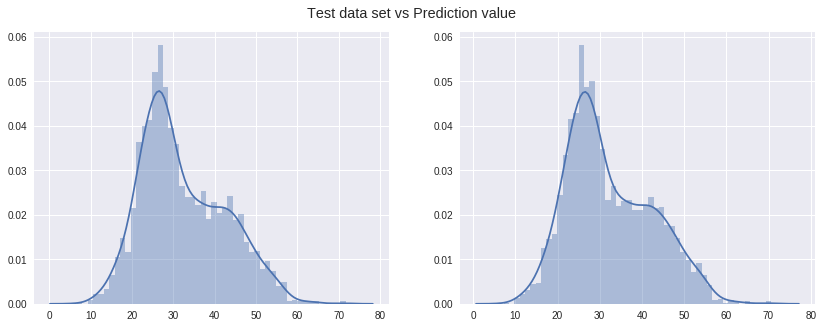

In [0]:
##예측값과 실제값 비교
pred = grid_result.predict(X_test)
fig,(ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(14,5)
sns.distplot(y_test, ax=ax1, bins=50)
fig.suptitle("Test data set vs Prediction value", y=0.95);
sns.distplot(pred, ax=ax2, bins=50)

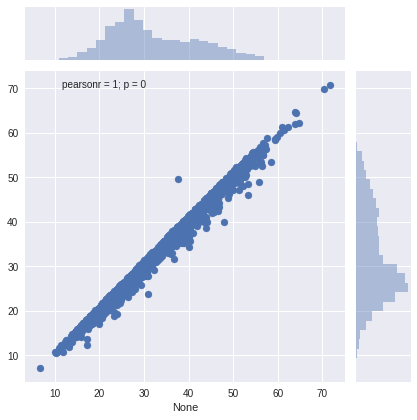

In [0]:
sns.jointplot(y_test, pred)

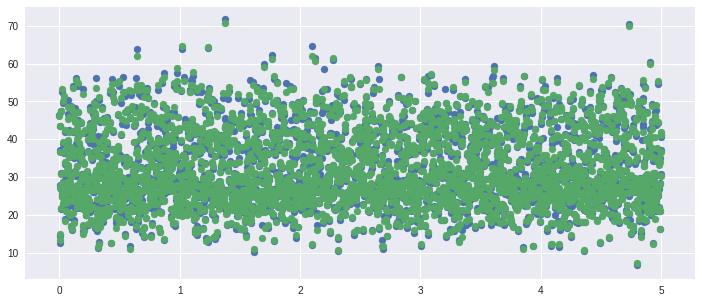

In [0]:
pred = grid_result.predict(X_test)
fig,ax = plt.subplots()
fig.set_size_inches(12, 5)
T = np.linspace(0, 5, len(y_test))[:, np.newaxis]
plt.scatter(T, y_test)
plt.scatter(T, pred)

In [0]:
plt.scatter(X0, y_test, label="data")
plt.plot(x_test, y_test, 'r-', label="회귀분석결과")
plt.xlabel("x")
plt.ylabel("y")
plt.title("릿지 회귀분석")
plt.legend()
plt.show()

NameError: ignored

### Lasso regression(Least Absolute Shrinkage and Selection Operator)
---
    선형회귀의 L1 Regularization를 적용하는 대안
    Objective = RSS + α * (sum of absolute value of coefficients)
    계수를 0에 가깝게 만들려고 하며 이를 L1 규제라고 한다. 어떤계수는 0이 되기도 하는 이는 완전히 제외하는 변수(피쳐)가 생긴다는 뜻이다. 
    alpha 기본값은 1.0이며, 과소 적합을 줄이기 위해서 이값을  줄여야한다. 

In [0]:
%%time
from sklearn.linear_model import Lasso
lasso_model = Lasso()


alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 5, 10, 20, 30]

param_grid = dict(max_iter=[10000], alpha = alphas)
##그리드 서치 : 회귀의 평가지표는 R^2이다. 
grid_lasso = GridSearchCV(lasso_model, param_grid, scoring='r2', cv=5)

grid_result=grid_lasso.fit(X_train, y_train)

pred = grid_result.predict(X_train)
print(grid_result.best_params_)
pred
print("릿지회귀에 대한 R^2값: {:.2f}".format(grid_result.best_score_))

{'alpha': 0.1, 'max_iter': 10000}
릿지회귀에 대한 R^2값: 0.99
CPU times: user 35.4 s, sys: 5.52 s, total: 40.9 s
Wall time: 33.2 s


In [0]:
grid_result.best_params_

{'alpha': 0.1, 'max_iter': 10000}

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


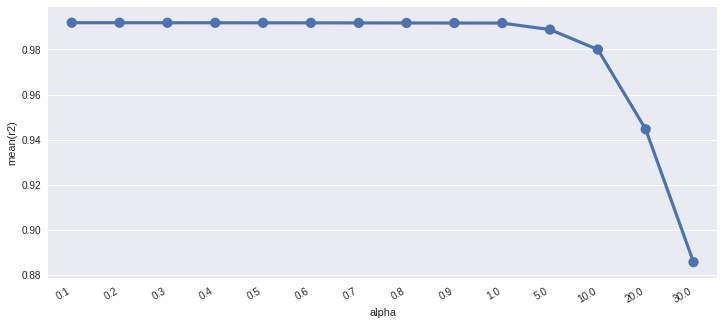

In [0]:
# 학습한 모형을 시각화
fig,ax = plt.subplots()
fig.set_size_inches(12, 5)
df = pd.DataFrame(grid_result.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x['alpha'])
df["r2"] = df["mean_validation_score"].apply(lambda x:x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df, x="alpha", y="r2", ax=ax)

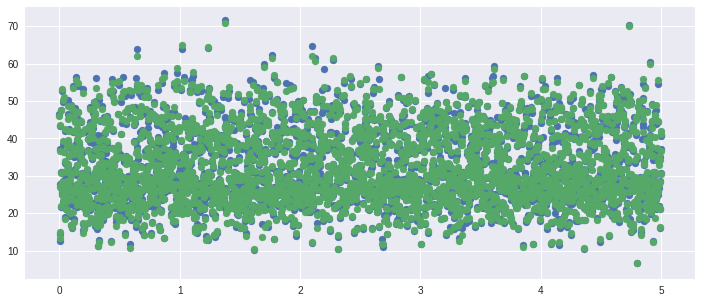

In [0]:
pred = grid_result.predict(X_test)
fig,ax = plt.subplots()
fig.set_size_inches(12, 5)
T = np.linspace(0, 5, len(y_test))[:, np.newaxis]
plt.scatter(T, y_test)
plt.scatter(T, pred)

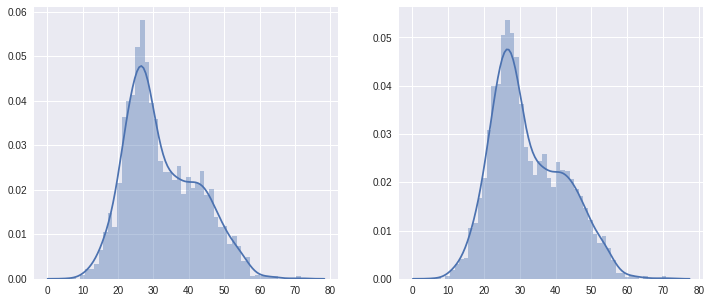

In [0]:
##훈련셋과 비교 하기
pred = grid_result.predict(X_test)
fig,(ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_test, ax=ax1, bins=50)
sns.distplot(pred, ax=ax2, bins=50)

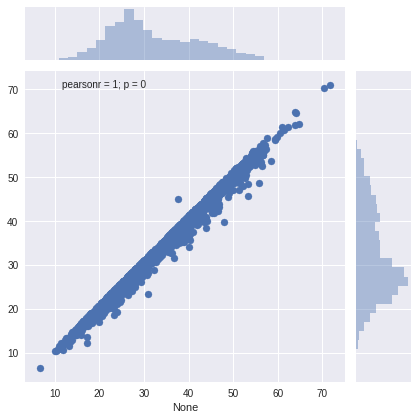

In [0]:
sns.jointplot(y_test, pred)

In [0]:
# MSE 계산
import numpy as np
mse = np.mean((pred - y_test)**2)
score = grid_result.score(X_test, y_test)
print("MSE: {:.5f}".format(mse))
print("Score: {:.3f}".format(score))

MSE: 0.86036
Score: 0.992


## 앙상블 그라디언트 부스트
---
    여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
    회귀, 분류로 사용하나 여기서는 회귀만 사용
    랜덤포레스트와 달리 이진 트리의 오차(?)를 보왕하는 방식으로 순차적 트리르 만든다. 
    깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠른게 장점
    learning_rate: 오차를 보정할것인가 제어
    n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련셋의 실수를 바로 잡을 기회가 많지만 너무크면 오버핏된다. 
    max_depath(max_leaf_nodes) 5보다 깊어지지 않게 하기

In [0]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor()

n_estimators = [50, 100]

alphas = [0.1, 0.25, 0.5, 0.75, 0.99]

lr = [0.1, 0.5]

param_grid = dict(n_estimators=n_estimators, alpha = alphas, learning_rate=lr)
##그리드 서치 : 회귀의 평가지표는 R^2이다. 
grid_gbr = GridSearchCV(gbr_model, param_grid, scoring='r2', cv=3)

grid_result=grid_gbr.fit(X_train, y_train)

pred = grid_result.predict(X_train)
print(grid_result.best_params_)

print("그라디언트 부스트 회귀에 대한 R^2값: {:.2f}".format(grid_result.best_score_))

{'alpha': 0.75, 'learning_rate': 0.5, 'n_estimators': 100}
그라디언트 부스트 회귀에 대한 R^2값: 1.00
CPU times: user 1min 45s, sys: 19.6 ms, total: 1min 45s
Wall time: 1min 45s


In [0]:
grid_result.score(X_test, y_test)

0.9987080578486597

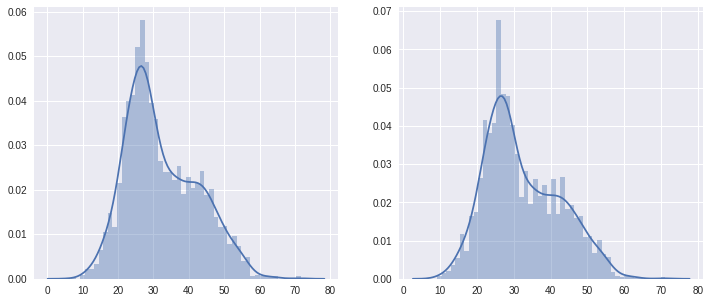

In [0]:
##훈련셋과 비교 하기
pred = grid_result.predict(X_test)
fig,(ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_test, ax=ax1, bins=50)
sns.distplot(pred, ax=ax2, bins=50)


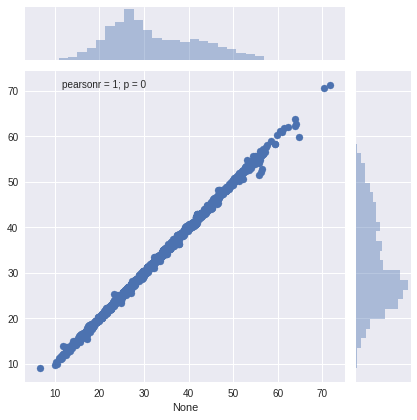

In [0]:
sns.jointplot(y_test, pred)

### SGDRegressor, (Stochastic Gradient Descent)
---
    class sklearn.linear_model.SGDRegressor(loss=’squared_loss’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, shuffle=True, verbose=0, epsilon=0.1, random_state=None, learning_rate=’invscaling’, eta0=0.01, power_t=0.25, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, warm_start=False, average=False, n_iter=None)
    
    Linear model fitted by minimizing a regularized empirical loss with SGD
    SGD는 정구화된 손실을 최소화하는 선형 모형
    
매개 변수

* loss : str, default: ‘squared_loss'
* penalty : str, ‘none’, ‘l2’, ‘l1’, or ‘elasticnet’
* alpha : float, Defaults to 0.0001 Also used to compute learning_rate when set to ‘optimal’.
* l1_ratio : float, The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1. l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1. Defaults to 0.15.
* fit_intercept : bool, Defaults to True.
* max_iter : int, optional, Defaults to 5. Defaults to 1000 from 0.21, or if tol is not None.
* tol : float or None, optional, Defaults to 1e-3 from 0.21.
* shuffle : bool, optional, Defaults to True

In [0]:
# 정규화 스케일러에 적용하기 위해서 구조를 바꾸어준다.
y_train_re = y_train.reshape(-1, 1)
y_test_re = y_test.reshape(-1, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [0]:
y_train_re.shape

(8492, 1)

In [0]:
# 자료를 정규화 한다. 


from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train_re)

X_train_sc = scaler_X.transform(X_train)
y_train_sc = scaler_y.transform(y_train_re)
X_test_sc = scaler_X.transform(X_test)
y_test_sc = scaler_y.transform(y_test_re)

In [0]:
#스케일 후 모형에 넣기 위해 다타원 배열을 1차원 배열로 변경
y_train_sc.ravel()

array([-0.94494728, -0.24745578,  0.00796364, ...,  0.45985953,
       -0.66988021,  0.78404572])

In [0]:
%%time

from sklearn.linear_model import SGDRegressor

sgd_model = SGDRegressor()

max_iter =[1000]


alphas = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75]

param_grid = dict(alpha = alphas, max_iter=max_iter)
##그리드 서치 : 회귀의 평가지표는 R^2이다. 
grid_gbr = GridSearchCV(sgd_model, param_grid, scoring='r2', cv=3)

grid_result=grid_gbr.fit(X_train_sc, y_train_sc.ravel())

print(grid_result.best_params_)

print("SGDRegressor에 대한 R^2값: {:.2f}".format(grid_result.best_score_))

{'alpha': 0.001, 'max_iter': 1000}
SGDRegressor에 대한 R^2값: 0.99
CPU times: user 1min 6s, sys: 1.53 s, total: 1min 7s
Wall time: 1min 5s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


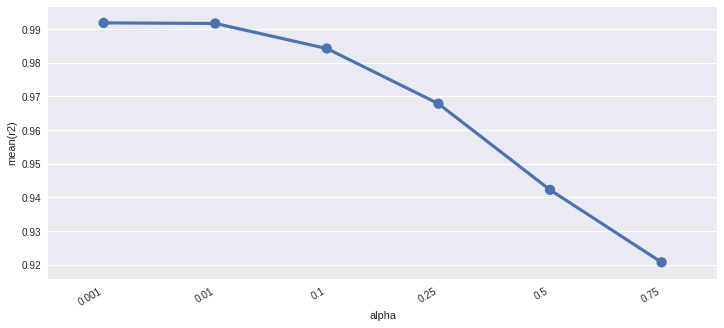

In [0]:
# 학습한 모형을 시각화
fig,ax = plt.subplots()
fig.set_size_inches(12, 5)
df = pd.DataFrame(grid_result.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x['alpha'])
df["r2"] = df["mean_validation_score"].apply(lambda x:x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df, x="alpha", y="r2", ax=ax)

In [0]:
# MSE 계산
import numpy as np
pred = grid_result.predict(X_test_sc)
mse = np.mean((pred - y_test_sc)**2)
score = grid_result.score(X_test_sc, y_test_sc.ravel())
print("MSE: {:.5f}".format(mse))
print("Score: {:.3f}".format(score))

MSE: 1.97337
Score: 0.991


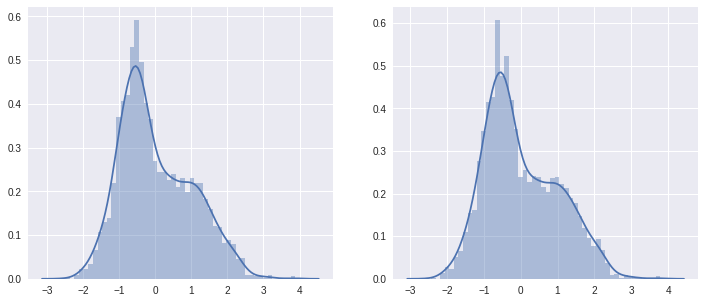

In [0]:
##훈련셋과 비교 하기
from sklearn.preprocessing import scale
pred = grid_result.predict(X_test_sc)

fig,(ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_test_sc, ax=ax1, bins=50)
sns.distplot(pred, ax=ax2, bins=50)
